In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob


In [2]:
csv_path = "D:/Dataset/Final2.csv"
df = pd.read_csv(csv_path)
columns_to_drop = ["Unnamed: 2", "Unnamed: 3"]
df = df.drop(columns=columns_to_drop)
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]
plt.figure(figsize=(8, 6))



<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

       label                                               text
0          0   Yawn..........: One of the least imaginative ...
1          0   Truely Bad!: Three stories, by three fairly r...
2          0   Breathtaking. . . .An Unforgettable Film: Ver...
3          0   Drama Par Excellence: Having viewed this movi...
4          0   WHAT a classic movie!: Excellent, superb phot...
...      ...                                                ...
36964      1  apartment manager already knows to look out fo...
37456      1  perverted wall gets off on making apartment gu...
41469      1     previous tenant clearly not bothered by mildew
4236       1  lives of mitch mcconnell, john boehner, eric c...
40532      1            consumer reports rates self 'excellent'

[169466 rows x 2 columns]


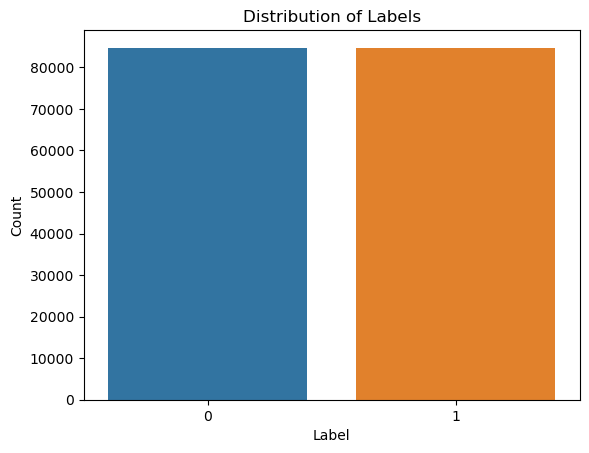

In [3]:
df_minority_upsampled = resample(df_minority,
                                 replace=True,  
                                 n_samples=len(df_majority), 
                                 random_state=42)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Split data into features (X) and labels (y)
X = df_upsampled['text'].values
y = df_upsampled['label'].values
sns.countplot(x='label', data=df_upsampled)
print(df_upsampled)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Show the plot
plt.show()

In [4]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
max_length = 128  # Set the maximum sequence length for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)

# Define class weights for handling imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

C:\Users\USER\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
embedding_dim = 100
lstm_units = 128

input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=embedding_dim, input_length=max_length)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(lstm_units))(embedding_layer)
dropout_layer = Dropout(0.5)(bi_lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

bi_lstm_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the Bi-LSTM model
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Bi-LSTM model
bi_lstm_model.fit(X_train_encoded['input_ids'], y_train, epochs=1, batch_size=64, class_weight=class_weight_dict)

# Evaluate the Bi-LSTM model
bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X_test_encoded['input_ids'], y_test)

print("Bi-LSTM Model - Loss:", bi_lstm_loss)
print("Bi-LSTM Model - Accuracy:", bi_lstm_accuracy)




1589/1589 [==============================] - 87s 54ms/step - loss: 0.0331 - accuracy: 0.9912
Bi-LSTM Model - Loss: 0.033104319125413895
Bi-LSTM Model - Accuracy: 0.9912077188491821


1589/1589 [==============================] - 77s 47ms/step
Testing Accuracy: 0.9912077104642014
Testing F1 Score: 0.9912402751376668
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     25406
           1       0.99      0.99      0.99     25434

    accuracy                           0.99     50840
   macro avg       0.99      0.99      0.99     50840
weighted avg       0.99      0.99      0.99     50840

The Accuracy is 0.9912077104642014


<Axes: >

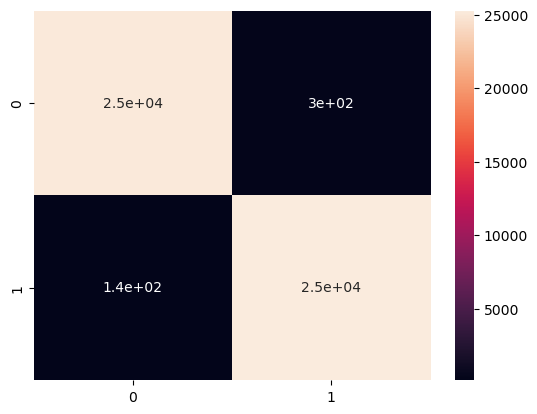

In [8]:
y_pred = bi_lstm_model.predict(X_test_encoded['input_ids'])
y_pred_labels = (y_pred > 0.5).astype(int)

# Print some evaluation metrics (e.g., accuracy)
accuracy = accuracy_score(y_test, y_pred_labels)
print("Testing Accuracy:", accuracy)
f1 = f1_score(y_test, y_pred_labels)
print("Testing F1 Score:", f1)
cm=confusion_matrix(y_test,y_pred_labels)
print(classification_report(y_test,y_pred_labels))
print("The Accuracy is",accuracy_score(y_test,y_pred_labels))
sns.heatmap(cm,annot=True)

In [14]:
user_input = input("Enter a text: ")
lstm_classification = classify_using_lstm(user_input)
print(lstm_classification)
if lstm_classification == 0:
    print("Non-sarcastic (From Sentimental Score)")
elif lstm_classification == 1:
    print("Sarcastic (From Sentimental Score)")
lstm_sarcasm_classification = classify_sarcasm_with_lstm(user_input)
if lstm_sarcasm_classification == 1:
    print("Sarcastic (Using BiLSTM)")
else:
    print("Non-sarcastic (Using BiLSTM)")
print("User Input:", user_input)


Enter a text: global perceptions of china as a superpower
0
Non-sarcastic (From Sentimental Score)
1/1 [==============================] - 0s 49ms/step
Non-sarcastic (Using BiLSTM)
User Input: global perceptions of china as a superpower


In [10]:
def preprocess_input(input_text):
    blob = TextBlob(input_text)
    sentiment_scores = [sentence.sentiment.polarity for sentence in blob.sentences]
    return sentiment_scores

In [11]:
def classify_sentiment_shifts(sentiment_scores): # Sentimental Scores:
    positive_count=0
    negative_count=0
    flag=0;
    prev_sentiment = sentiment_scores[0]
    for sentiment in sentiment_scores[1:]:

        if prev_sentiment > 0 and sentiment>=0 :
            positive_count=positive_count+1
        elif prev_sentiment >0 and sentiment<= 0:
            negative_count=negative_count+1
            prev_sentiment=sentiment
            flag=1;
            continue
        elif prev_sentiment< 0 and sentiment <=0 and flag==1:
            negative_count=negative_count+1
        elif prev_sentiment < 0 and sentiment >=0 and flag==1:
            positive_count=positive_count+1
        prev_sentiment=sentiment
    if positive_count > negative_count or negative_count > positive_count:
        return 0
    elif positive_count ==0 and negative_count==0:
        return 0
    else:
        return 1


In [12]:
def classify_using_lstm(input_text):
    sentiment_scores = preprocess_input(input_text)
    classification = classify_sentiment_shifts(sentiment_scores)

    return classification

def classify_sarcasm_with_lstm(input_text):
    input_encoded = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    prediction = bi_lstm_model.predict(input_encoded['input_ids'])
    prediction_label = 1 if prediction > 0.7 else 0

    return prediction_label

In [54]:
# Build the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = Input(shape=(max_length,), dtype=tf.int32)
attention_mask = Input(shape=(max_length,), dtype=tf.int32)
embeddings = bert_model(input_ids, attention_mask=attention_mask)[0]  # Use [0] to extract embeddings
dropout_layer = Dropout(0.5)(embeddings)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

bert_classifier = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Compile the BERT model
bert_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the BERT model
y_train_repeated = np.repeat(y_train.reshape(-1, 1), max_length, axis=1)
y_test_repeated = np.repeat(y_test.reshape(-1, 1), max_length, axis=1)

# Train the BERT model with repeated labels
bert_classifier.fit([X_train_encoded['input_ids'], X_train_encoded['attention_mask']], y_train_repeated, epochs=1, batch_size=16, class_weight=class_weight_dict)

# Evaluate the BERT model with repeated labels
bert_loss, bert_accuracy = bert_classifier.evaluate([X_test_encoded['input_ids'], X_test_encoded['attention_mask']], y_test_repeated)

print("BERT Model - Loss:", bert_loss)
print("BERT Model - Accuracy:", bert_accuracy)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

 43/171 [======>.......................] - ETA: 15:32 - loss: 0.9843 - accuracy: 0.5397

KeyboardInterrupt: 